In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm
import tqdm
import time

np.random.seed(42)

## Implement logistic regression from scratch.


$$\textrm{log-likelihood, }\ell(\theta) = \log L(\theta) = \sum_{i=1}^n \left[ y^{(i)} \log h_\theta(x^{(i)}) + (1 - y^{(i)}) \log (1 - h_\theta(x^{(i)})) \right]$$

$$ \mathbf{\implies \ell(\theta)} = \mathbf{Y}.log(\mathbf{h_\theta(X)}) + (1 - \mathbf{Y}). log(\mathbf{1 - h_\theta(X)}) $$


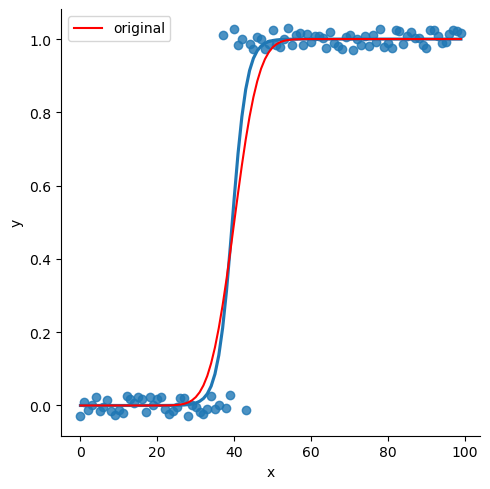

In [136]:
# for simplicity the dimensions of the data , X is 100, 1 only

# creating custom binary classification data
data_x = np.arange(0, 100)
X = np.column_stack([data_x, np.ones(data_x.shape)])

# using the gaussian cdf to generate desired probabilities
probabilities = norm.cdf(data_x, loc=40, scale=5)
random_vals = np.random.random(data_x.shape)

data_y = np.where(random_vals < probabilities, 1, 0)

df = pd.DataFrame({'x': data_x, 'y': data_y})
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, probabilities, color='red', label='original')
plt.legend()

In [137]:
# intial theta
# theta_initial = np.array([-10, -60], dtype='float64')
theta_initial = np.array([0, 0], dtype='float64')

# writing the function to be maximised
def sigmoid(x):
    return 1/(1 + np.exp(-x))


for gradient ascent
$$ \theta : = \theta + \alpha \nabla_\theta \ell (\theta )$$
for stochastic gradient ascent
$$ \theta_j : = \theta_j + \alpha \big( y^{(i)} - h(x^{(i)}) \big)x_j^{(i)} $$

where $\alpha$ is the learning rate
$\theta$ in our case is of dimensions $(2,1)$

In [232]:
# class of all optimizers

class optimize:
    def __init__(self, x, y):
        """
        x and y should be 1d array of same size
        """
        self.x = x
        self.y = y
        self.X = np.column_stack([self.x, np.ones(self.x.shape[0])])

    def _batch_gradient_ascent_update(self, theta, alpha): 
        h = sigmoid(np.dot(self.X, theta))
        grad = np.dot(self.X.T, (self.y-h))

        return theta + alpha * grad
    
    def _fisher_update(self, theta, alpha, epsilon=1e-8):
        p = np.vectorize(sigmoid)(self.X.dot(theta))
        w = np.multiply(p, 1-p)
        
        W = np.diag(np.clip(w, epsilon, None)) # prevents any 0 value in the diagonal which can cause singular matrix error

        z = self.X.dot(theta) + alpha * np.linalg.inv(W).dot(self.y - p)
        return np.linalg.inv(self.X.T @ W @ self.X) @ self.X.T @ W @ z
        
    def calculate_mse(self, theta):
        loss_arr = np.square(self.y - sigmoid(np.dot(self.X, theta)))

        return loss_arr.sum()/loss_arr.shape[0]

    def _train_epochs(self, update_rule, theta_initial, learning_rate, epochs):
        t0 = time.time()
        theta = theta_initial.copy()

        # storing history for displaying graph
        history_theta = np.zeros((epochs+1, theta.shape[0]))
        history_theta[0] = theta

        history_loss = np.zeros(epochs+1,)
        history_loss[0] = self.calculate_mse(theta)

        # to run through dataset fixed iterations

        for epoch in range(epochs):
            theta = update_rule(theta, learning_rate)
            
            history_theta[epoch+1] = theta
            history_loss[epoch+1] = self.calculate_mse(theta)

        
        print(f'done in {time.time() - t0:.3f}s')
        return {'theta': theta, 'history_theta': history_theta, 'history_loss': history_loss}
    
    def _train_epsilon(self, update_rule, theta_initial, learning_rate, epsilon):
        t0 = time.time()
        theta = theta_initial.copy()

        # storing history for displaying graph
        history_theta = []
        history_theta.append(theta)

        history_loss = []
        history_loss.append(self.calculate_mse(theta))

        # to stop when theta converges
        while True:
            theta_new = update_rule(theta, learning_rate)
            if np.linalg.norm(theta_new - theta) < epsilon:
                break
            theta = theta_new

            history_theta.append(theta)
            history_loss.append(self.calculate_mse(theta))    

        print(f'done in {time.time() - t0:.3f}s')
        return {'theta': theta, 'history_theta': history_theta, 'history_loss': history_loss}

    def batch_gradient_ascent(self, theta_initial, learning_rate, epochs, epsilon=None):
        if epochs==None:
            return self._train_epsilon(self._batch_gradient_ascent_update, theta_initial, learning_rate, epsilon)
        else:
            return self._train_epochs(self._batch_gradient_ascent_update, theta_initial, learning_rate, epochs)
    
    def fisher_scoring(self, theta_initial, learning_rate, epochs, epsilon=None):
        if epochs==None:
            return self._train_epsilon(self._fisher_update, theta_initial, learning_rate, epsilon)
        else:
            return self._train_epochs(self._fisher_update, theta_initial, learning_rate, epochs)
    
    

In [238]:
optimizer = optimize(data_x, data_y)

In [239]:
bgd = optimizer.batch_gradient_ascent(theta_initial, learning_rate=5e-4, epochs=1000000)

done in 27.313s


Text(0.5, 1.0, 'loss')

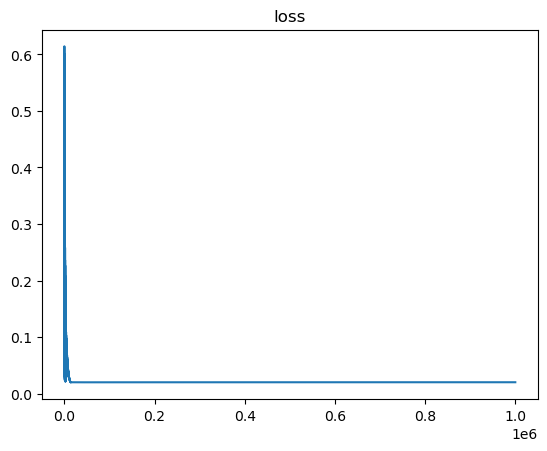

In [240]:
plt.plot(bgd['history_loss'])
plt.title('loss')

Text(0.5, 1.0, 'prediction')

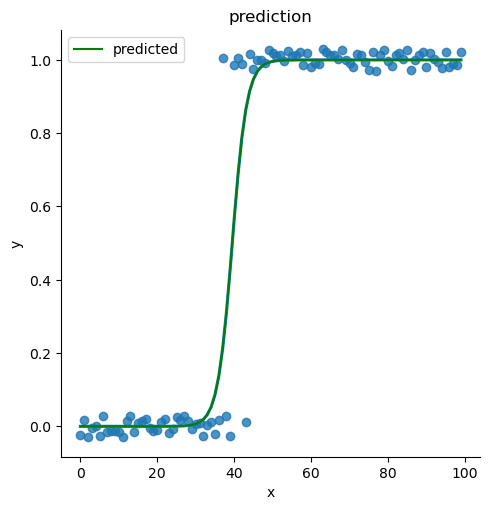

In [241]:
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, sigmoid(np.dot(X, bgd['theta'])), color='green', label='predicted')
plt.legend()
plt.title('prediction')

Text(0, 0.5, 'theta1(intercept)')

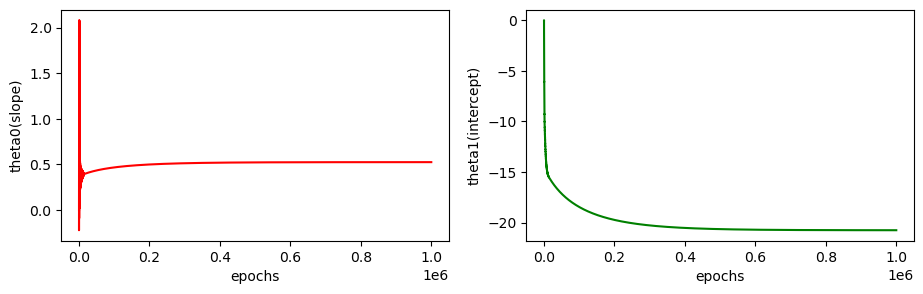

In [242]:
plt.figure(figsize=(11, 3))
plt.subplot(1,2,1)
plt.plot(bgd['history_theta'][:, 0], color='red')
plt.xlabel('epochs')
plt.ylabel('theta0(slope)')


plt.subplot(1,2,2)
plt.plot(bgd['history_theta'][:, 1], color='green')
plt.xlabel('epochs')
plt.ylabel('theta1(intercept)')

In [243]:
fisher = optimizer.fisher_scoring(theta_initial, learning_rate=1, epochs=10)

done in 0.005s


Text(0.5, 1.0, 'loss')

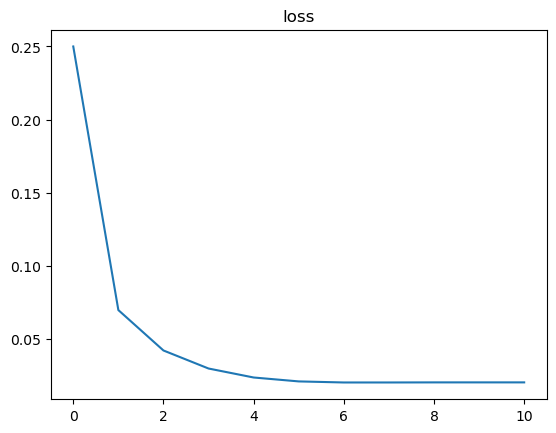

In [244]:
plt.plot(fisher['history_loss'])
plt.title('loss')

Text(0.5, 1.0, 'prediction')

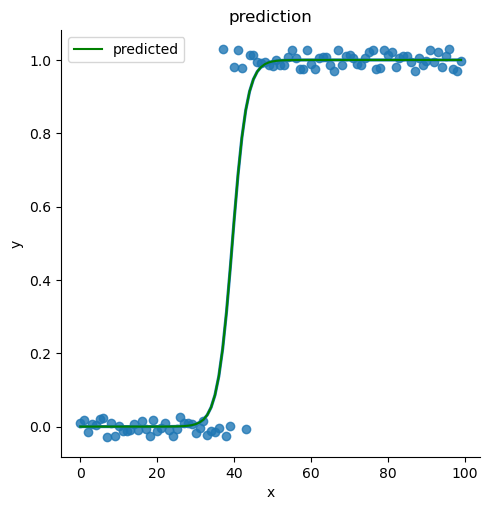

In [245]:
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, sigmoid(np.dot(X, fisher['theta'])), 'g', label='predicted')
plt.legend()
plt.title('prediction')

Text(0, 0.5, 'theta1(intercept)')

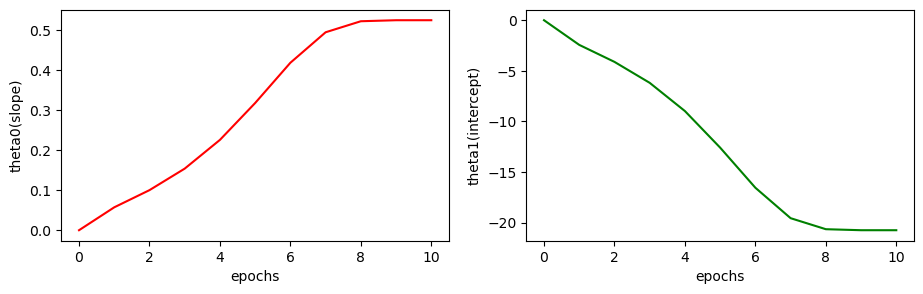

In [246]:
plt.figure(figsize=(11, 3))
plt.subplot(1,2,1)
plt.plot(fisher['history_theta'][:, 0], color='red')
plt.xlabel('epochs')
plt.ylabel('theta0(slope)')


plt.subplot(1,2,2)
plt.plot(fisher['history_theta'][:, 1], color='green')
plt.xlabel('epochs')
plt.ylabel('theta1(intercept)')

as we see newton-fisher's method took only 10 epochs and around 5 ms to converge, as compared to the batch gradient ascent which took around 1e6 epochs and 30 seconds

also I observed that bgd was highly dependent on the learning rate whereas it has hardly any effect on the newton's method